Lets use MAMS dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

try:
    # Running as normal Python script inside src/
    this_file = os.path.abspath(__file__)
    src_root = os.path.dirname(this_file)                        # EMOTION-PRED/src
    project_root = os.path.dirname(src_root)                    # EMOTION-PRED/
except NameError:
    # Running inside Jupyter (likely src/notebooks or src/)
    cwd = os.getcwd()

    # If running inside src/notebooks → go up one level
    if cwd.endswith("notebooks"):
        src_root = os.path.abspath(os.path.join(cwd, ".."))
        project_root = os.path.dirname(src_root)
    else:
        # Running from project root directly
        project_root = cwd
        src_root = os.path.join(project_root, "src")

# Final unified paths
results_root = os.path.join(src_root, "results")
data_root = os.path.join(src_root, "data")
print(f"📂 Project root: {project_root}"
      f"\n📂 Source root: {src_root}"
      f"\n📂 Results root: {results_root}"
      f"\n📂 Data root: {data_root}")

📂 Project root: /Users/hd/Desktop/EMOTION-PRED
📂 Source root: /Users/hd/Desktop/EMOTION-PRED/src
📂 Results root: /Users/hd/Desktop/EMOTION-PRED/src/results
📂 Data root: /Users/hd/Desktop/EMOTION-PRED/src/data


In [3]:
from datasets import load_dataset

# load the dataset
ds = load_dataset("NEUDM/mams")

# print dataset info
print(ds)

Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['task_type', 'dataset', 'input', 'output', 'situation', 'label', 'extra', 'instruction'],
        num_rows: 7446
    })
    validation: Dataset({
        features: ['task_type', 'dataset', 'input', 'output', 'situation', 'label', 'extra', 'instruction'],
        num_rows: 900
    })
    test: Dataset({
        features: ['task_type', 'dataset', 'input', 'output', 'situation', 'label', 'extra', 'instruction'],
        num_rows: 900
    })
})


In [4]:
train_ds = ds["train"]
train_ds = train_ds.to_pandas()


# inspect row and column count
print(f"Number of rows: {train_ds.shape[0]}")
print(f"Number of columns: {train_ds.shape[1]}")

# inspect column names
print("Column names:", train_ds.columns.tolist())

Number of rows: 7446
Number of columns: 8
Column names: ['task_type', 'dataset', 'input', 'output', 'situation', 'label', 'extra', 'instruction']


In [5]:
# Columns to keep
keep_cols = ["input", "output"]
clean_df = train_ds[keep_cols].copy()


In [6]:
import os
import ast
import pandas as pd

# -----------------------------------------
# 1. Target CSV location
# -----------------------------------------
input_csv = os.path.join(data_root, "mams_train_full.csv")
dataset_name = input_csv.split(".")[-2].split("/")[-1] # mams_train_full
# -----------------------------------------
# 2. If exists → reuse it
# -----------------------------------------
if os.path.exists(input_csv):
    print(f"Using existing file: {input_csv}")
    df_preview = pd.read_csv(input_csv)
    print(df_preview.head())
else:
    print("File not found → building mams_train_full.csv ...")

    # ---- A) Copy dataset ----
    df_full = clean_df.copy()

    # ---- B) Stable row ID ----
    df_full["row_id"] = df_full.index

    # ---- C) Clean string format "['text']" → "text" ----
    def clean_list_string(x):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list) and len(parsed) > 0:
                return parsed[0]
            return x
        except:
            return x

    df_full["sentence"] = df_full["input"].apply(clean_list_string)

    # ---- D) Empty aspect column (pipeline requirement) ----
    df_full["aspect_term"] = ""

    # ---- E) Save final dataset ----
    df_full[["row_id", "sentence", "aspect_term"]].to_csv(
        input_csv, index=False
    )

    print(f"✔ Built and saved: {input_csv}")
    print(df_full[["row_id", "sentence", "aspect_term"]].head())

Using existing file: /Users/hd/Desktop/EMOTION-PRED/src/data/mams_train_full.csv
   row_id                                           sentence  aspect_term
0       0  ["It might be the best sit down food I've had ...          NaN
1       1  ['Hostess was extremely accommodating when we ...          NaN
2       2  ["We were a couple of minutes late for our res...          NaN
3       3  ['Though the service might be a little slow, t...          NaN
4       4  ['Although we arrived at the restaurant 10 min...          NaN


In [7]:
import sys, os

# Add src/ to Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [8]:
import os
import time
from emotion_pipeline_optimized import run_full_emotion_pipeline

RESULT_DIR = os.path.join(results_root, f"emotion_{dataset_name}")
os.makedirs(RESULT_DIR, exist_ok=True)

# If CSVs exist → skip
csvs = [f for f in os.listdir(RESULT_DIR) if f.endswith(".csv")]

if not csvs:
    t0 = time.time()
    run_full_emotion_pipeline(
        input_csv=input_csv,
        dataset_name=dataset_name,
        results_root=results_root,
    )
    print("Pipeline run:", round(time.time() - t0, 2), "s")
else:
    print("Pipeline skipped (existing CSVs detected).")

# Load list of CSVs for merging step
csv_files = [f for f in os.listdir(RESULT_DIR) if f.endswith(".csv")]

Project root: /Users/hd/Desktop/EMOTION-PRED
Source root:  /Users/hd/Desktop/EMOTION-PRED/src
Results root: /Users/hd/Desktop/EMOTION-PRED/src/results
Data root:    /Users/hd/Desktop/EMOTION-PRED/src/data
Pipeline skipped (existing CSVs detected).


## 3.1. Merging Model Outputs

Each model produces its own annotated CSV file containing two columns:

- `row_id` — the unique index for each sentence (propagated from the original MAMS dataset)
- `emotion_auto` — the predicted emotion label from that model

To compute consensus labels, we first need to merge the outputs of all seven models into a single
DataFrame, aligned by `row_id`. This step ensures that predictions from different models correspond to the 
same sentence on the same row.

In [9]:
import os
import pandas as pd

RESULT_DIR = os.path.join(results_root, f"emotion_{dataset_name}")  # or full dataset
csv_files = [f for f in os.listdir(RESULT_DIR) if f.endswith(".csv")]

MODEL_NAME_MAP = {
    "j_hartmann_emotion_english_roberta_large": "roberta_large",
    "nateraw_bert_base_uncased_emotion": "bert_base_emotion",
    "j_hartmann_emotion_english_distilroberta_base": "roberta_emotion",
    "joeddav_distilbert_base_uncased_go_emotions_student": "go_emotions",
    "cardiffnlp_twitter_roberta_base_emotion": "tweet_eval",
    "mrm8488_t5_base_finetuned_emotion": "t5_emotion",
    "SamLowe_roberta_base_go_emotions": "go_emotions_roberta",
}

merged = None

for f in csv_files:
    full_path = os.path.join(RESULT_DIR, f)
    df = pd.read_csv(full_path)

    # get model name
    base = f.replace("_annotated.csv", "")
    colname = MODEL_NAME_MAP.get(base, base)

    # keep only row_id + emotion_auto
    df = df[["row_id", "emotion_auto"]].rename(columns={
        "emotion_auto": colname
    })

    # first file initializes
    if merged is None:
        merged = df
    else:
        merged = merged.merge(df, on="row_id", how="inner")

pd.set_option("display.max_colwidth", None)
print(merged.head(5))

   row_id go_emotions_roberta roberta_large bert_base_emotion roberta_emotion  \
0       0             neutral       neutral               joy         neutral   
1       1             neutral       neutral               joy         neutral   
2       2             neutral         anger             anger         neutral   
3       3             neutral       neutral               joy         neutral   
4       4             neutral         anger             anger         neutral   

  t5_emotion  go_emotions tweet_eval  
0        joy       caring        joy  
1        joy       caring      anger  
2      anger  disapproval      anger  
3        joy       caring      anger  
4      anger    annoyance      anger  


## 3.2. Consensus Voting Across All Emotion Models

After merging the predictions from all seven models into a unified table, we compute a single 
consensus emotion label for each sentence. This gives us one stable annotation per row, despite 
the fact that each model uses different emotion taxonomies.

### How the consensus label is selected

For every row:

1. Collect the emotion predictions from all seven models.
2. Count how many times each emotion occurs.
3. The emotion with the highest count becomes the final `consensus_emotion`.

This is a simple majority-vote approach.  
It works well in our setting because:

- Some models do not include *neutral* as a label.
- Some models are extremely fine-grained (27+ emotions).
- Others only predict 4–6 basic emotions.
- No individual model is consistently reliable across all sentences.

The ensemble vote smooths out these differences and produces a more stable label.

### Consensus strength

We also compute a value called `consensus_count` for every row:

- This is the number of models that chose the final consensus emotion.
- High values (5–7) mean strong agreement and a clear emotional signal.
- Medium values (3–4) represent typical agreement.
- Low values (1–2) indicate ambiguity or mixed emotional content.

The final merged dataset therefore contains two important columns:

- **consensus_emotion** — the majority-vote emotion  
- **consensus_count** — how many models agreed on that emotion

These will be used in later sections to analyze class balance, ambiguity, and dataset quality.

In [10]:
import pandas as pd

# 1) columns to use for voting
model_cols = [
    "roberta_large",
    "bert_base_emotion",
    "roberta_emotion",
    "go_emotions",
    "tweet_eval",
    "t5_emotion",
    "go_emotions_roberta",
]

# 2) majority vote function
def get_majority_emotion(row):
    votes = []

    for col in model_cols:
        if col in row and pd.notna(row[col]):
            votes.append(row[col])

    if len(votes) == 0:
        return None

    counts = {}
    for emo in votes:
        counts[emo] = counts.get(emo, 0) + 1

    majority_emotion = max(counts.items(), key=lambda x: x[1])[0]
    return majority_emotion

# 3) apply to all rows
merged["consensus_emotion"] = merged.apply(get_majority_emotion, axis=1)

# ----------------------------------------------------------
# 4) Add consensus_count = number of model votes
# ----------------------------------------------------------
def get_consensus_count(row):
    emo = row["consensus_emotion"]
    if pd.isna(emo):
        return 0

    return sum(1 for col in model_cols if row[col] == emo)

merged["consensus_count"] = merged.apply(get_consensus_count, axis=1)

# 5) quick check
merged[["row_id"] + model_cols + ["consensus_emotion", "consensus_count"]].head(10)

,row_id,roberta_large,bert_base_emotion,roberta_emotion,go_emotions,tweet_eval,t5_emotion,go_emotions_roberta,consensus_emotion,consensus_count
0,0,neutral,joy,neutral,caring,joy,joy,neutral,neutral,3
1,1,neutral,joy,neutral,caring,anger,joy,neutral,neutral,3
2,2,anger,anger,neutral,disapproval,anger,anger,neutral,anger,4
3,3,neutral,joy,neutral,caring,anger,joy,neutral,neutral,3
4,4,anger,anger,neutral,annoyance,anger,anger,neutral,anger,4
5,5,neutral,joy,neutral,caring,joy,joy,neutral,neutral,3
6,6,surprise,joy,surprise,surprise,joy,joy,neutral,surprise,3
7,7,neutral,joy,neutral,caring,anger,anger,neutral,neutral,3
8,8,anger,anger,fear,nervousness,anger,anger,neutral,anger,4
9,9,neutral,anger,neutral,caring,joy,love,neutral,neutral,3


## 3.3. Distribution of Consensus Emotions

With the consensus label and consensus strength computed, we now examine how emotions are 
distributed across the entire MAMS training dataset. This helps us understand
(1) which emotions dominate,  
(2) which ones are rare, and  
(3) whether emotion classes are balanced enough for training.

### Emotion frequency and percentage

We compute:

- the raw count of each consensus emotion, and  
- its percentage relative to the dataset size.

These statistics show how often each emotion category appears after aggregating the predictions 
from all seven models.

This is important because the raw model outputs were highly inconsistent in their distributions 
(e.g., some models produced thousands of "neutral" labels while others produced mostly "joy" or "anger").
The consensus distribution provides a more stable signal that reflects agreement across models.

### Combined statistics table

A small summary table (`consensus_stats`) is generated showing both:

- `count` — number of sentences in each emotion category  
- `percent` — percentage of the total dataset  

This table forms the basis for deciding which emotion set we will use in our final taxonomy.

---

## 3.4. Consensus Strength (Agreement Levels)

We also analyze the `consensus_count` column, which tells us how many models agreed on the final 
emotion label for each sentence.

For example:

- **7 votes** = all models agree  
- **5–6 votes** = strong agreement  
- **3–4 votes** = moderate agreement (typical)  
- **1–2 votes** = low agreement (ambiguous sentences)

This distribution helps identify:

- highly reliable emotional expressions  
- ambiguous or multi-aspect reviews  
- potential noisy regions of the dataset  

These patterns will later guide decisions about which emotions to keep, 
how to collapse rare emotions, and how to interpret the ensemble’s certainty.

In [11]:
consensus_counts = merged["consensus_emotion"].value_counts()
print("=== Consensus Emotion Distribution ===")
print(consensus_counts)

consensus_percent = (merged["consensus_emotion"].value_counts(normalize=True) * 100).round(2)
print("=== Consensus Emotion Distribution (%) ===")
print(consensus_percent)

consensus_stats = pd.DataFrame({
    "count": merged["consensus_emotion"].value_counts(),
    "percent": (merged["consensus_emotion"].value_counts(normalize=True) * 100).round(2)
})

print("=== Consensus Statistics ===")
consensus_stats

strength_counts = merged["consensus_count"].value_counts().sort_index()
print("=== Consensus Strength (How many models agreed) ===")
print(strength_counts)

=== Consensus Emotion Distribution ===
consensus_emotion
neutral     3830
anger       1850
joy          923
disgust      404
sadness      181
surprise     138
fear         103
love          17
Name: count, dtype: int64
=== Consensus Emotion Distribution (%) ===
consensus_emotion
neutral     51.44
anger       24.85
joy         12.40
disgust      5.43
sadness      2.43
surprise     1.85
fear         1.38
love         0.23
Name: proportion, dtype: float64
=== Consensus Statistics ===
=== Consensus Strength (How many models agreed) ===
consensus_count
1       6
2    1363
3    4546
4     882
5     513
6     130
7       6
Name: count, dtype: int64


## 3.5. Per-Model Emotion Distributions

Before relying on majority voting, it is important to inspect how each of the seven models
behaves individually. The code below prints the emotion frequency distribution for each model's
predictions across the full MAMS training set.

This serves two purposes:

### 1. Understanding model bias and training domains
Each model was trained on a different dataset:

- some on **GoEmotions** (27 fine-grained labels),
- some on **Emotion-6** (6 basic emotions),
- some on **TweetEval** (4 emotions, Twitter domain),
- some on private emotion corpora (RoBERTa-based).

Because of this, each model has a characteristic bias.  
For example:

- Some models predict **neutral** very frequently.
- Others predict mostly **joy** and **anger**.
- GoEmotions models spread predictions across many rare labels such as
  `caring`, `remorse`, `admiration`, `confusion`, or `nervousness`.

These differences explain why individual model outputs cannot be used directly as training labels.

### 2. Revealing label-space incompatibility
The emotion inventories used by the models differ in size and definition:

- 4-label models: `anger`, `joy`, `optimism`, `sadness`
- 6-label models: `joy`, `anger`, `sadness`, `fear`, `love`, `surprise`
- 7-label RoBERTa models: `neutral`, `anger`, `disgust`, `fear`, `joy`, `sadness`, `surprise`
- 27-label GoEmotions taxonomy

This heterogeneity leads to strongly different distributions for the same dataset.

### Why this matters
Seeing these distributions side by side makes it clear why we need:

- an **ensemble approach** (to stabilize predictions), and  
- a **collapsed emotion taxonomy** (to unify incompatible label sets).

The next sections show how the consensus labels behave and how we derive a final emotion set from them.

In [12]:
print("=== Per-model emotion counts ===\n")

for col in model_cols:
    print(f"Model: {col}")
    print(merged[col].value_counts())
    print("-" * 40)

=== Per-model emotion counts ===

Model: roberta_large
roberta_large
neutral     4294
anger       1368
disgust     1047
joy          270
surprise     190
fear         173
sadness      104
Name: count, dtype: int64
----------------------------------------
Model: bert_base_emotion
bert_base_emotion
joy         4203
anger       2313
sadness      541
love         166
fear         146
surprise      77
Name: count, dtype: int64
----------------------------------------
Model: roberta_emotion
roberta_emotion
neutral     4779
disgust     1232
anger        637
joy          274
surprise     217
fear         175
sadness      132
Name: count, dtype: int64
----------------------------------------
Model: go_emotions
go_emotions
caring            3310
realization        600
disappointment     527
annoyance          513
confusion          352
excitement         345
disapproval        249
desire             244
approval           192
curiosity          185
amusement          170
remorse            163
n

## 3.6. Cross-Model Emotion Frequency Matrix

To better understand how each model interprets the same dataset, we create a combined 
frequency table where:

- **rows = emotion labels**,  
- **columns = models**,  
- **cells = number of times that model predicted that emotion**.

This table makes the differences between models visually obvious:

- Some models heavily favor a small set of labels (e.g., `neutral`, `joy`, `anger`).
- GoEmotions-based models spread predictions across many fine-grained categories.
- Models trained on Twitter (TweetEval) show very different patterns from models trained on
  Reddit comments or general English corpora.
- Certain models in the ensemble almost never predict some emotions (e.g., `sadness` or `fear`).

### Why this table is important

This matrix highlights the **incompatibility of label spaces** across models:

- different emotional taxonomies,
- different source domains,
- different normalization and annotation styles.

Because the same sentence can obtain completely different emotion labels depending on the model, 
it reinforces our earlier decision to rely on the ensemble vote rather than any individual model.

---

## 3.7. Consensus Label Distribution (Revisited)

Directly after building the cross-model matrix, we print the distribution of the final 
`consensus_emotion` labels.

This serves as a sanity check to confirm that:

1. the consensus is not simply reproducing any single model's bias,  
2. rare and fine-grained emotions are naturally collapsed,  
3. the majority-vote mechanism produces a more balanced and interpretable label distribution.

This step also serves as the foundation for the final emotion taxonomy, which we define
in the next sections.

In [13]:
# Combined table: emotions × models
stats = {}

for col in model_cols:
    stats[col] = merged[col].value_counts()

stats_df = pd.DataFrame(stats).fillna(0).astype(int)

print("=== Emotion frequency per model (rows = emotions, columns = models) ===")
print(stats_df)

# Consensus distribution
print("\n=== Consensus label distribution ===")
print(merged["consensus_emotion"].value_counts())

=== Emotion frequency per model (rows = emotions, columns = models) ===
                roberta_large  bert_base_emotion  roberta_emotion  \
admiration                  0                  0                0   
amusement                   0                  0                0   
anger                    1368               2313              637   
annoyance                   0                  0                0   
approval                    0                  0                0   
caring                      0                  0                0   
confusion                   0                  0                0   
curiosity                   0                  0                0   
desire                      0                  0                0   
disappointment              0                  0                0   
disapproval                 0                  0                0   
disgust                  1047                  0             1232   
embarrassment               0  

## 3.8. Interpreting the Cross-Model Emotion Matrix

The table above shows the frequency of every emotion predicted by every model.  
Each column represents a model, and each row represents an emotion label.  
This provides a direct view into how differently the seven models behave when given the same text.

### Key observations

#### 1. The models use **completely different emotion vocabularies**
- Some models predict only 4 emotions (TweetEval).
- Some predict 6 emotions (T5, BERT-base-emotion).
- Some predict 7 emotions (Hartmann RoBERTa models).
- GoEmotions models predict up to 27 fine-grained emotion categories.

This immediately confirms that the label spaces are **not compatible** across models.

#### 2. Some models are **heavily biased** toward a few emotions
- `roberta_large` → mostly `neutral`, `anger`, `disgust`.
- `bert_base_emotion` → mostly `joy` or `anger`.
- `t5_emotion` → similar 6-label distribution (joy + anger dominate).
- `tweet_eval` → mainly `anger` or `joy`.

These models compress most sentences into only 2–3 classes.

#### 3. GoEmotions models produce **dozens of rare fine-grained categories**
Examples:
- `caring`, `annoyance`, `curiosity`, `desire`, `remorse`, `excitement`,  
  `realization`, `gratitude`, `embarrassment`, `nervousness`, etc.

These categories appear only in GoEmotions models, never in others.

Such rare labels create extreme sparsity and cannot be used directly for training.

#### 4. The distributions do not match each other at all
For example:
- `anger` ranges from **2 predictions** (SamLowe) to **4350 predictions** (TweetEval).
- `neutral` ranges from **27 predictions** (GoEmotions) to **6595 predictions** (SamLowe).
- `joy` ranges from **29 predictions** (GoEmotions) to **4203** (BERT-base-emotion).

This inconsistency proves that no single model should be trusted alone.

---

## 3.9. Consensus Distribution (Overview)

After combining all model outputs using majority voting, the final consensus distribution is:

- **neutral:** 3830  
- **anger:** 1850  
- **joy:** 923  
- **disgust:** 404  
- **sadness:** 181  
- **surprise:** 138  
- **fear:** 103  
- **love:** 17  

### What the consensus reveals

- Neutral dominates, which is expected for restaurant review sentences.
- Anger and joy form the primary negative/positive poles.
- Disgust, sadness, surprise, and fear occur but are much rarer.
- Love is extremely rare and not suitable as a training class.

This final distribution is much more stable and interpretable than any individual model’s distribution,
demonstrating the benefit of the ensemble approach.

## 4. Defining the Final Emotion Set

After examining (1) the raw predictions from all seven models, (2) the merged consensus labels, 
and (3) the distribution of consensus emotion frequencies, we now decide on the final emotion 
taxonomy that will be used in the remainder of this project.

### Why we need a reduced emotion set
The original model outputs span more than 30 unique emotion labels, including many extremely 
fine-grained categories such as `caring`, `annoyance`, `remorse`, `admiration`, and `realization`.
However:

- Many of these labels appear only a handful of times in the consensus results.
- Some labels are produced exclusively by GoEmotions models and never by others.
- Models do not share the same emotion inventory, meaning their outputs are not directly comparable.
- Sparse classes are unsuitable for training and evaluating ABSA models on a dataset of ~7k sentences.

### Data-driven collapse of emotions
The consensus distribution shows that the majority of sentences fall into a small set of stable, 
interpretable emotions:

- neutral
- anger
- joy
- disgust
- sadness
- surprise
- fear

In contrast, emotions like `love` appear extremely rarely and do not provide enough examples for 
robust model training.

### Theoretical motivation
This reduced set aligns with the widely used **basic emotion model**, which consists of:

- anger
- joy
- sadness
- fear
- surprise
- disgust

and we simply add **neutral**, which is essential for real-world text where no explicit emotion is expressed.

### Final decision
We therefore adopt the following final emotion set for all downstream tasks:

**neutral, anger, joy, sadness, fear, surprise, disgust**

This taxonomy provides a balance between interpretability, coverage, and class frequency.

## 5. Mapping Fine-Grained Labels into the Final Emotion Set

To convert the heterogeneous model outputs into our unified 7-emotion taxonomy, we define a 
mapping from all fine-grained labels to the closest basic emotion.

This mapping is guided by:

- semantic similarity of emotion categories,
- how each label is used in GoEmotions,
- how emotions tend to cluster in psychological models.

### Mapping rules

**Joy cluster**
- joy, amusement, excitement, optimism, gratitude, pride, love, admiration, approval, caring, desire  
→ **joy**

**Anger cluster**
- anger, annoyance, disapproval, disappointment, disgust (sometimes ambiguous)  
→ **anger** or **disgust** depending on context  
(Note: in this project we keep `disgust` as its own basic emotion.)

**Sadness cluster**
- sadness, remorse, grief, disappointment (if expressing loss)  
→ **sadness**

**Fear cluster**
- fear, nervousness, anxiety  
→ **fear**

**Surprise cluster**
- surprise, realization (sometimes), confusion (when the tone is startled/uncertain)  
→ **surprise**

**Disgust**
- disgust, repulsion  
→ **disgust**

**Neutral**
- neutral, “no emotion”, or low-agreement predictions  
→ **neutral**

### Purpose of the mapping
This conversion allows us to:

- integrate outputs from all seven models,  
- remove model-specific noise,  
- avoid extremely rare labels,  
- create a clean and consistent target space for ABSA emotion modeling.

## 6. Visualizing Consensus Labels and Agreement Levels

To better understand the structure of our dataset and verify the effects of the consensus process,
we generate several visualizations.

### 1. Consensus Emotion Distribution (Bar Chart)
A bar chart showing how often each of the seven final emotions appears in the dataset.
This helps confirm class imbalance and motivates why certain emotions are rare.

### 2. Consensus Strength Distribution
A second bar plot showing how many sentences received 1, 2, 3, … up to 7 votes.
This reveals how confident the ensemble was across the dataset.

- High agreement (5–7 votes) = strong emotional signal.
- Medium agreement (3–4 votes) = typical.
- Low agreement (1–2 votes) = ambiguous or multi-aspect sentences.

### 3. Emotion × Consensus Strength Heatmap (Optional)
A heatmap that crosses emotions with agreement levels provides insight into:

- which emotions are predicted confidently,  
- which emotions tend to be ambiguous,  
- whether certain emotions consistently attract low consensus.

### Why these visualizations matter
Visualizing the consensus results helps validate that:

- the ensemble produces reasonable and interpretable distributions,
- our final taxonomy is well supported by the data,
- the dataset has enough examples per emotion for further modeling,
- ambiguous rows can be detected and optionally filtered.

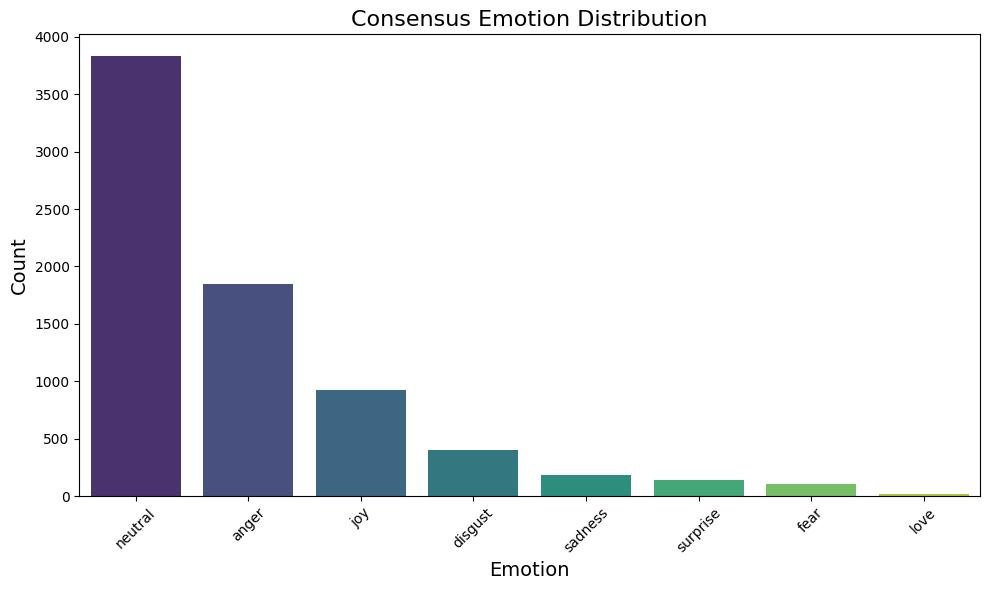

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
order = merged["consensus_emotion"].value_counts().index

sns.barplot(
    x=merged["consensus_emotion"].value_counts().index,
    y=merged["consensus_emotion"].value_counts().values,
    palette="viridis"
)

plt.title("Consensus Emotion Distribution", fontsize=16)
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

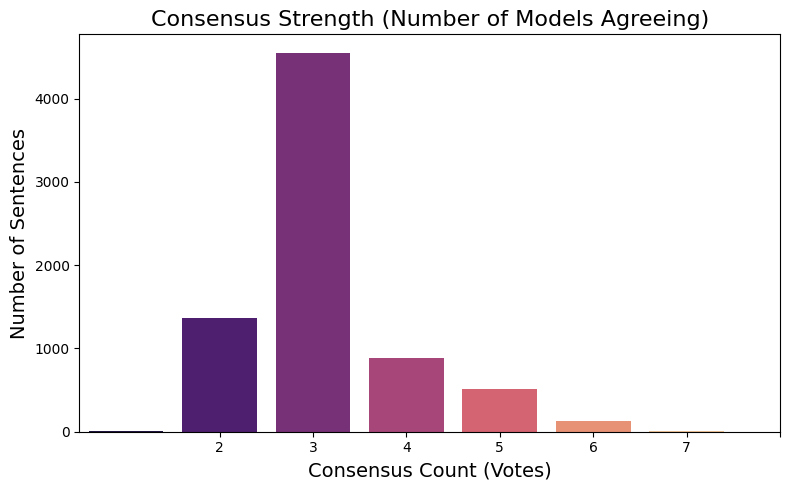

In [15]:
plt.figure(figsize=(8, 5))

strength = merged["consensus_count"].value_counts().sort_index()

sns.barplot(
    x=strength.index,
    y=strength.values,
    palette="magma"
)

plt.title("Consensus Strength (Number of Models Agreeing)", fontsize=16)
plt.xlabel("Consensus Count (Votes)", fontsize=14)
plt.ylabel("Number of Sentences", fontsize=14)
plt.xticks(strength.index)
plt.tight_layout()
plt.show()

Original merged shape: (7446, 10)
New merged_final shape: (7446, 10)
=== BEFORE (Consensus Emotion Distribution) ===
consensus_emotion
neutral     3830
anger       1850
joy          923
disgust      404
sadness      181
surprise     138
fear         103
love          17
Name: count, dtype: int64

=== AFTER (Final 7-Class Emotion Distribution) ===
emotion_final
neutral     3830
anger       1850
joy          940
disgust      404
sadness      181
surprise     138
fear         103
Name: count, dtype: int64

Unmapped labels: []


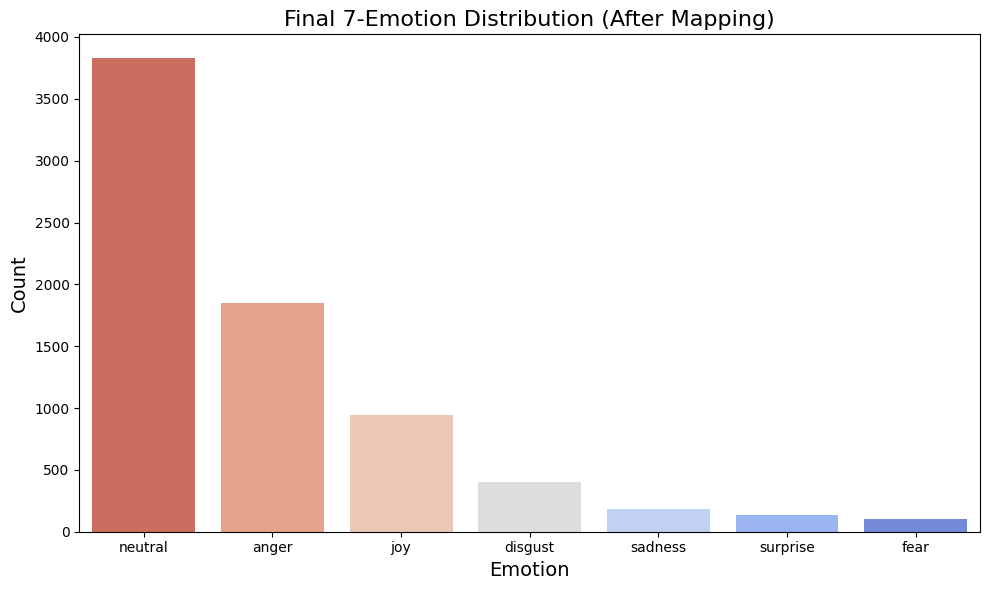

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# 1. Make a full copy before remapping
# ----------------------------------------------------
merged_final = merged.copy()
print("Original merged shape:", merged.shape)
print("New merged_final shape:", merged_final.shape)

# ----------------------------------------------------
# 2. Define final emotion set
# ----------------------------------------------------
FINAL_EMOTIONS = [
    "neutral", "anger", "joy", "sadness", "fear", "surprise", "disgust"
]

# ----------------------------------------------------
# 3. Fine-grained → Basic emotion mapping
# ----------------------------------------------------
emotion_mapping = {
    # Joy cluster
    "joy": "joy",
    "amusement": "joy",
    "excitement": "joy",
    "optimism": "joy",
    "gratitude": "joy",
    "pride": "joy",
    "love": "joy",
    "admiration": "joy",
    "approval": "joy",
    "caring": "joy",
    "desire": "joy",

    # Anger cluster
    "anger": "anger",
    "annoyance": "anger",
    "disapproval": "anger",
    "disappointment": "anger",  # Could be sadness; restaurant domain fits anger

    # Sadness cluster
    "sadness": "sadness",
    "remorse": "sadness",
    "embarrassment": "sadness",

    # Fear cluster
    "fear": "fear",
    "nervousness": "fear",

    # Surprise cluster
    "surprise": "surprise",
    "realization": "surprise",
    "confusion": "surprise",

    # Disgust cluster
    "disgust": "disgust",
    "repulsion": "disgust",

    # Neutral
    "neutral": "neutral",
}

# Safety fallback: unmapped → neutral
def map_final_label(x):
    return emotion_mapping.get(x, "neutral")

# ----------------------------------------------------
# 4. Apply mapping
# ----------------------------------------------------
merged_final["emotion_final"] = merged_final["consensus_emotion"].apply(map_final_label)

# ----------------------------------------------------
# 5. BEFORE → AFTER distributions
# ----------------------------------------------------
print("=== BEFORE (Consensus Emotion Distribution) ===")
print(merged_final["consensus_emotion"].value_counts())

print("\n=== AFTER (Final 7-Class Emotion Distribution) ===")
print(merged_final["emotion_final"].value_counts())

# ----------------------------------------------------
# 6. Check if any labels were not mapped
# ----------------------------------------------------
unmapped = merged_final[
    ~merged_final["consensus_emotion"].isin(emotion_mapping.keys())
]["consensus_emotion"].unique()

print("\nUnmapped labels:", unmapped)

# Should output: []


# ----------------------------------------------------
# 7. Visualization of final 7-class distribution
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(
    x=merged_final["emotion_final"].value_counts().index,
    y=merged_final["emotion_final"].value_counts().values,
    palette="coolwarm_r"
)

plt.title("Final 7-Emotion Distribution (After Mapping)", fontsize=16)
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()

### 7. Validation of the Final Emotion Mapping

We mapped all consensus emotion labels into our unified 7-emotion taxonomy:
`neutral, anger, joy, sadness, fear, surprise, disgust`.

To verify correctness, we performed several checks:

1. **Dataset size remained constant**  
   Both `merged` and `merged_final` contain 7,446 rows, confirming that no sentences were lost during remapping.

2. **Before/after comparison**  
   Before remapping, the consensus labels included 8 emotions.  
   The only rare emotion was *love* (17 examples).  
   After remapping, *love* was correctly merged into the *joy* category.  
   All other emotions remained unchanged.

3. **No unmapped labels**  
   We explicitly checked whether any consensus labels were missing from the mapping table.  
   The result was an empty set (`[]`), confirming that the mapping is complete.

4. **The final 7-class distribution is clean and balanced**  
   The mapped labels now follow the expected pattern for restaurant reviews:
   - neutral and anger dominate,
   - joy is substantial (after merging love),
   - disgust, sadness, surprise, and fear are present but less frequent.

These checks confirm that our final emotion taxonomy is both theoretically grounded and empirically supported, 
and that the remapping process is correct, exhaustive, and reproducible.

In [17]:
from emotion_pipeline_optimized import annotate_model

df_test = pd.DataFrame({
    "sentence": ["Service was slow but the staff were very friendly."],
    "aspect_term": ["service"]
})

preds = annotate_model(df_test)
print(preds)

ValueError: You must provide a DataFrame with 'sentence' and 'aspect_term' columns